# Imports

In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
import numpy as np
import sounddevice as sd
import cv2
from scipy.signal import iirnotch, filtfilt
from glob import glob
from tqdm import tqdm

# Load Data

In [2]:
sub_files = glob('../../../*/*.xdf')
sub_files

['../sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [3]:
xdf_path = sub_files[3]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['WebcamStream',
 'Tobii',
 'OpenSignals',
 'EGI NetAmp 0',
 'Stimuli_Markers',
 'Microphone']

# Stimulus

In [4]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,2.000000e+02,Onset_Experiment,1.073920e+06,0.000000e+00
1,1.735058e+09,psychopy_time_stamp,1.073920e+06,9.799609e-09
2,1.000000e+01,Onset_RestingState,1.073940e+06,1.976684e-02
3,1.735058e+09,psychopy_time_stamp,1.073940e+06,1.976685e-02
4,1.100000e+01,Offset_RestingState,1.074240e+06,3.197662e-01
...,...,...,...,...
256,1.735060e+09,psychopy_time_stamp,1.076101e+06,2.180627e+00
257,2.010000e+02,Offset_Experiment,1.076106e+06,2.185632e+00
258,1.735060e+09,psychopy_time_stamp,1.076106e+06,2.185632e+00
259,4.000000e+00,Bx_input,1.076106e+06,2.185633e+00


# Physio

In [9]:
PS

{'info': defaultdict(list,
             {'name': ['OpenSignals'],
              'type': ['00:07:80:8C:06:8C'],
              'channel_count': ['7'],
              'nominal_srate': ['500'],
              'channel_format': ['float32'],
              'source_id': ['OpenSignals'],
              'version': ['1.1000000000000001'],
              'created_at': ['3103477.6006140001'],
              'uid': ['2b6d58e8-d47b-41d8-86e7-05942e602063'],
              'session_id': ['default'],
              'hostname': ['C4-BIOSIGNALS'],
              'v4address': [None],
              'v4data_port': ['16572'],
              'v4service_port': ['16572'],
              'v6address': [None],
              'v6data_port': ['16572'],
              'v6service_port': ['16572'],
              'desc': [defaultdict(list,
                           {'manufacturer': ['OpenSignals'],
                            'channels': [defaultdict(list,
                                         {'channel': [defaultdict(list,
   

In [5]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000
ps_df

,nSeq,RESPIRATION0,ECG1,EDA2,fSpO23,fSpO24,%SpO25,lsl_time_stamp,time
0,110775.0,-0.02582,1.45963,2.6134,0.55642,1.06794,27.0,1.073908e+06,0.000000
1,110776.0,-0.02637,1.46269,2.6154,0.55640,1.06793,27.0,1.073908e+06,0.000002
2,110777.0,-0.02582,1.45568,2.6161,0.55640,1.06793,27.0,1.073908e+06,0.000004
3,110778.0,-0.02618,1.44463,2.6161,0.55637,1.06789,27.0,1.073908e+06,0.000006
4,110779.0,-0.02582,1.43448,2.6173,0.55631,1.06791,27.0,1.073908e+06,0.000008
...,...,...,...,...,...,...,...,...,...
1176795,1287570.0,-0.01520,-0.34941,7.1915,0.53018,1.08721,22.0,1.076263e+06,2.354392
1176796,1287571.0,-0.01474,-0.27475,7.1899,0.53009,1.08728,22.0,1.076263e+06,2.354394
1176797,1287572.0,-0.01520,-0.21240,7.1884,0.53009,1.08732,22.0,1.076263e+06,2.354396
1176798,1287573.0,-0.01520,-0.15220,7.1899,0.53015,1.08730,22.0,1.076263e+06,2.354398


In [6]:
ps_exp = get_event_data('Experiment', ps_df, stim_df=stim_df)
start = ps_exp['lsl_time_stamp'].values[0]
stop = ps_exp['lsl_time_stamp'].values[-1]
ps_dur = stop - start
ps_dur


2185.630074840039

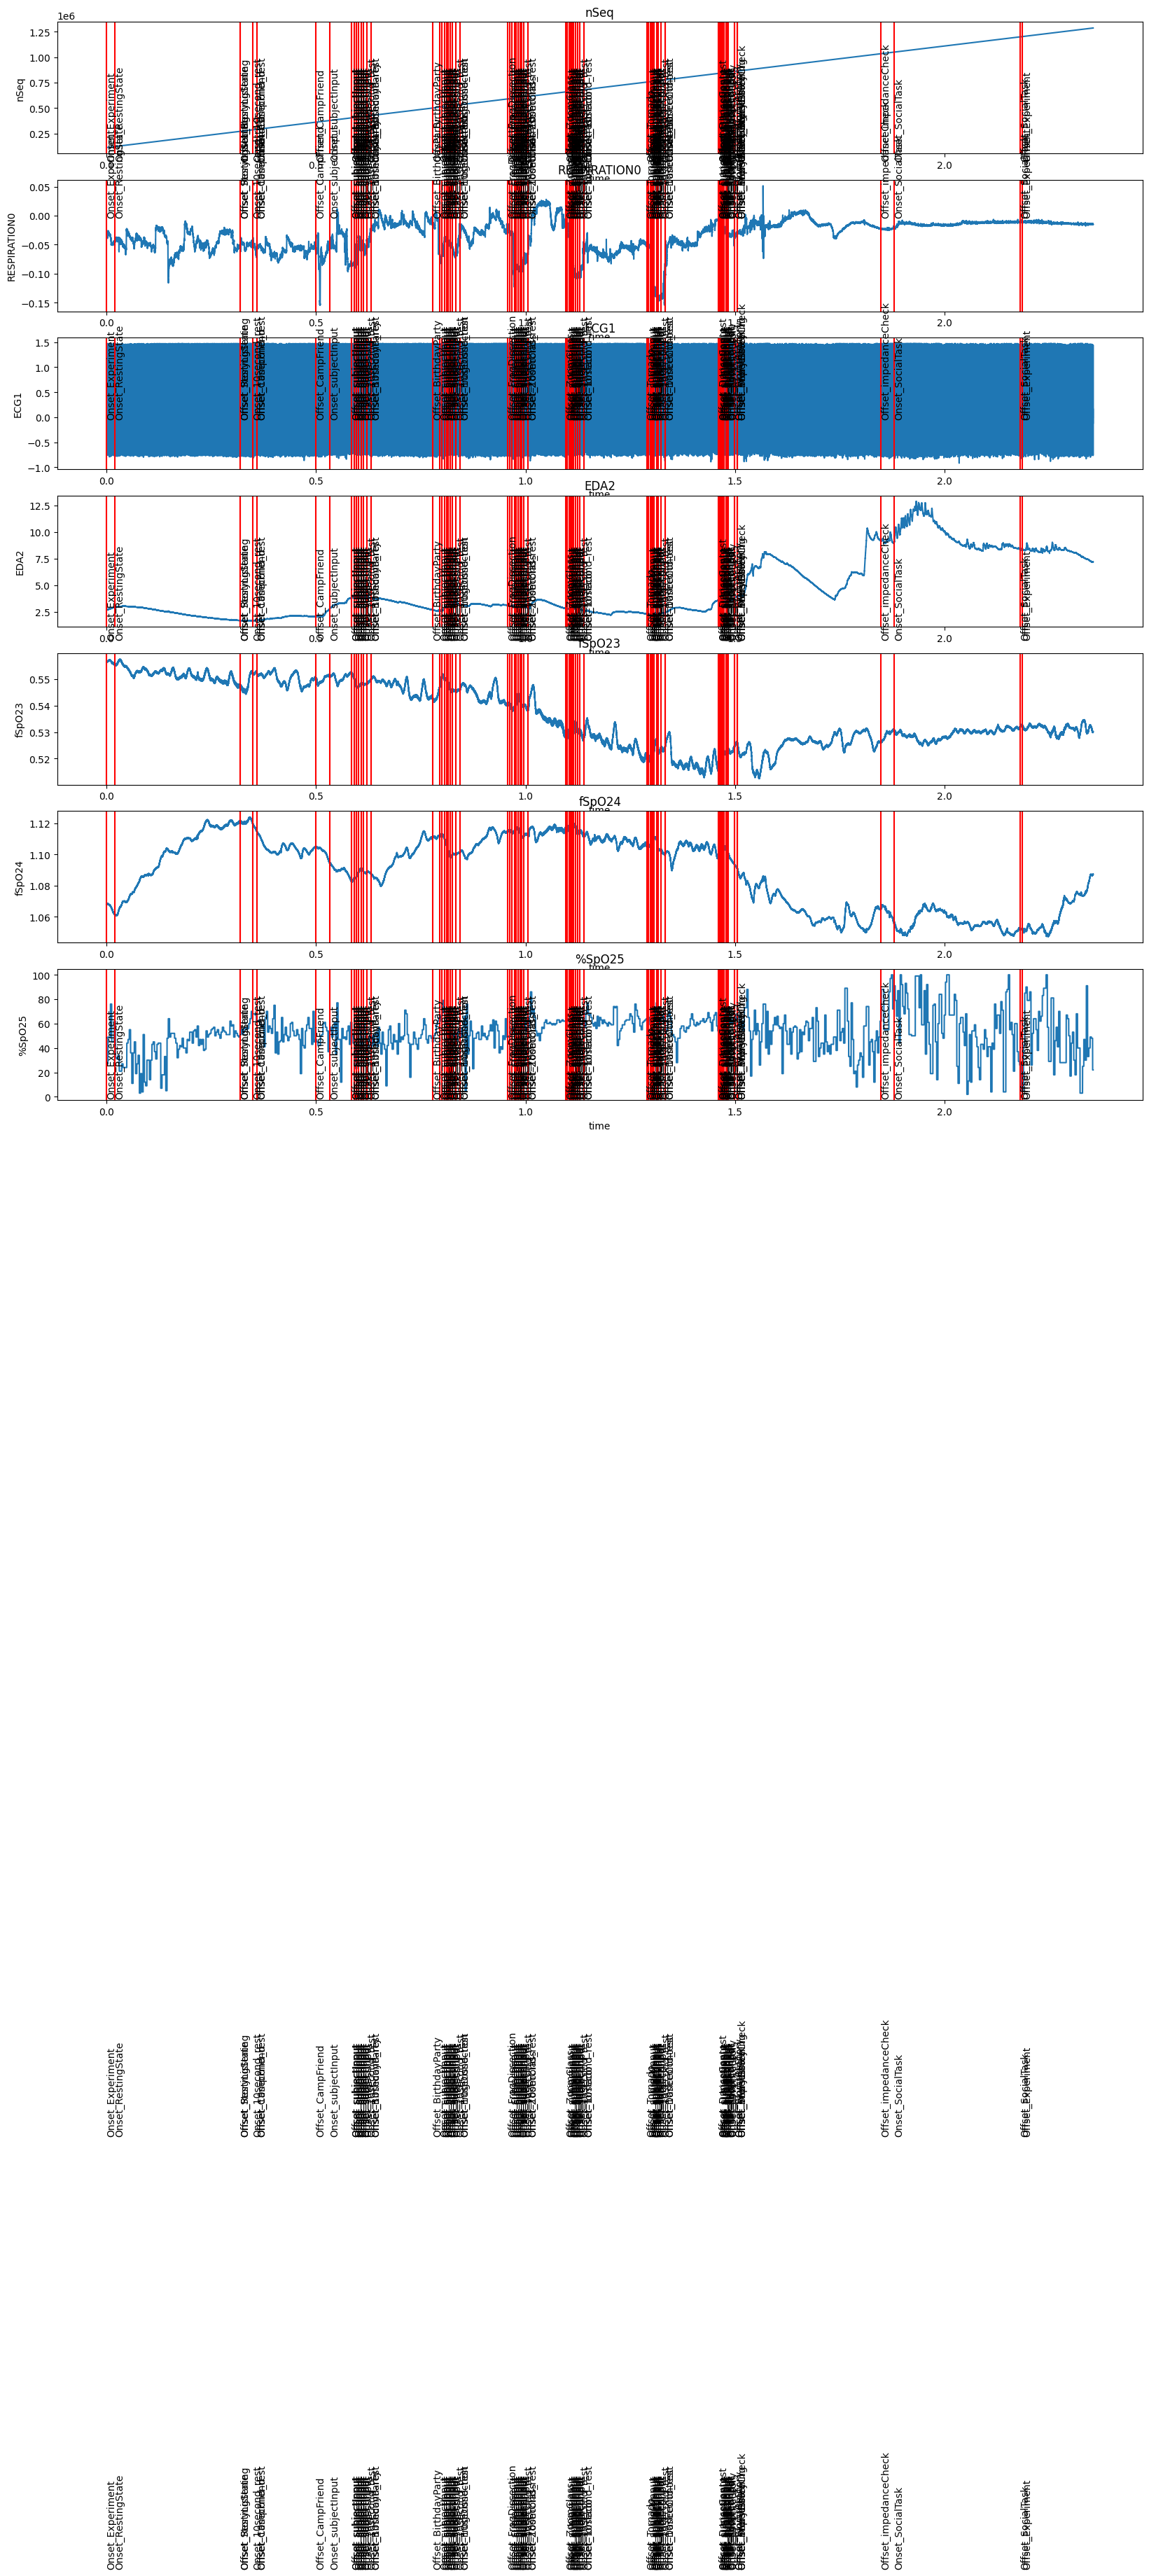

In [7]:
    
'''
# Plot every column in one plot
'''
# confirm all events are in the stim_df
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']

f, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
for i, col in enumerate(column_labels):
    
    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=ps_df, x='time', y=col, ax=ax[i])
    # Place and Vline at every event in evs with onset and offset
    for event in evs.iterrows():
        # If the word Onset or Offset is in the event, plot a vertical line at the time of the event

        if "Onset" in event[1]['event'] or "Offset" in event[1]['event']:
            ax[i].axvline(event[1]['time'], color='r')
            ax[i].text(event[1]['time'], 0, event[1]['event'], rotation=90)
        
    ax[i].set_title(col)
    #plt.show()

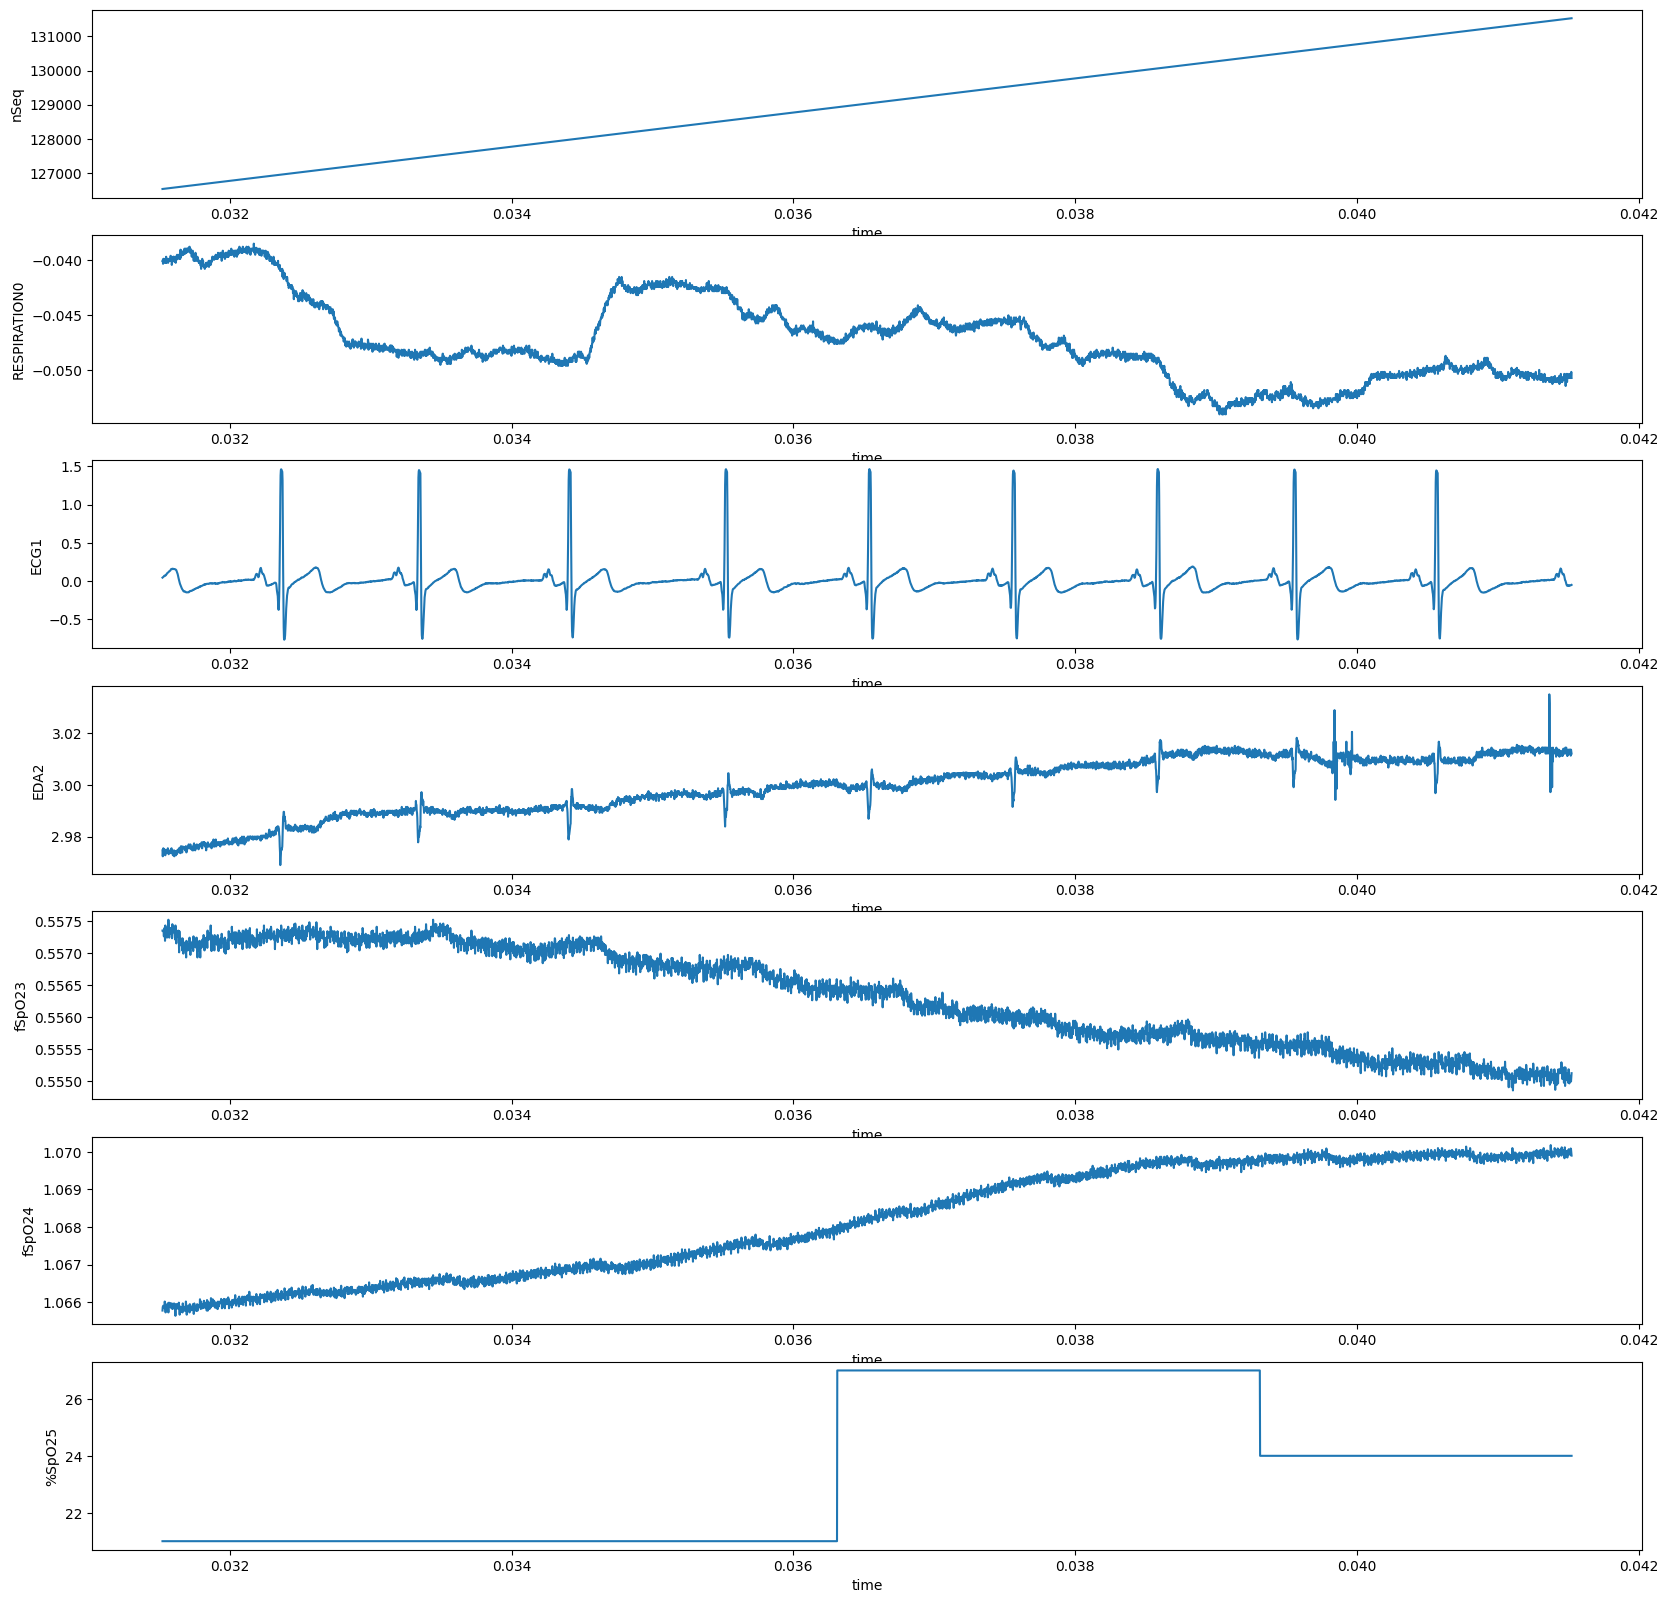

In [8]:
physio_resting_state = get_event_data('RestingState', ps_df, stim_df)
fig, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=physio_resting_state[:5000], x='time', y=col, ax=ax[i])